In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [2]:
# The generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(94*94*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((94, 94, 256)))
    assert model.output_shape == (None, 94, 94, 256)
    
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 188, 188, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 376, 376, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 752, 752, 3)
    return model


# The discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[752,752,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


@tf.function
def train_step(images):
    noise =  tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator,epoch + 1,seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.show()

In [3]:
# noise = tf.random.normal([1,100])
# generated_image = generator(noise, training=False)
# plt.imshow(generated_image[0])

# discriminator = make_discriminator_model()
# decision = discriminator(generated_image)
# print(decision)

In [4]:
# Directory containing your training images
data_dir = ""

# List files in the directory
file_list = os.listdir(data_dir)

def load_and_preprocess_image(image_path, target_height=752, target_width=752):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and preprocess all images in the directory
images = []
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)
    image = load_and_preprocess_image(file_path)
    images.append(image)

# Convert list of images to TensorFlow tensor
images = tf.convert_to_tensor(images)

# Print shape of the resulting tensor
print("Shape of images tensor:", images.shape)

Shape of images tensor: (70, 752, 752, 3)


In [5]:
EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 4
BUFFER_SIZE = len(images)
BATCH_SIZE = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])


train_dataset = tf.data.Dataset.from_tensor_slices(images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


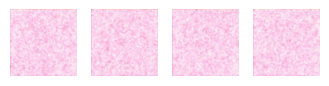

Time for epoch 1 is 194.61343455314636 sec


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


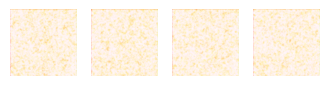

Time for epoch 2 is 198.35806679725647 sec


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


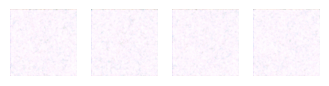

Time for epoch 3 is 198.36371183395386 sec


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


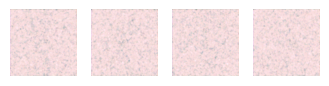

Time for epoch 4 is 197.49107217788696 sec


In [ ]:
# Train the GAN model
train(train_dataset, 10)